## Big Data and Apache Spark

In [68]:
! pip install pandas matplotlib seaborn

In [69]:
! pip install pyspark==3.3.2

In [70]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark Session
spark = SparkSession.builder.appName("RetailSalesAnalysis").getOrCreate()

# Load CSV
file_path = r"C:\Users\aquil\ostds\assign5_spark\retail_sales_dataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Preview schema & first rows
df.printSchema()
df.show(5)


root
 |-- Transaction ID: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price per Unit: integer (nullable = true)
 |-- Total Amount: integer (nullable = true)

+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|Transaction ID|      Date|Customer ID|Gender|Age|Product Category|Quantity|Price per Unit|Total Amount|
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|             1|2023-11-24|    CUST001|  Male| 34|          Beauty|       3|            50|         150|
|             2|2023-02-27|    CUST002|Female| 26|        Clothing|       2|           500|        1000|
|             3|2023-01-13|    CUST003|  Male| 50|     Electronics|       1|            30

In [71]:
# Drop rows with any null values
df_clean = df.dropna()

# Remove duplicate records
df_clean = df_clean.dropDuplicates()

# Ensure Quantity and Price_per_Unit are of numeric type (if needed)
df_clean = df_clean.withColumn("Quantity", col("Quantity").cast("float"))
df_clean = df_clean.withColumn("Price per Unit", col("Price per Unit").cast("float"))

# Filter out unrealistic quantities or prices
df_clean = df_clean.filter((col("Quantity") > 0) & (col("Price per Unit") > 0))

# Show the cleaned data
df_clean.show(5)

# Print the schema to verify column types
df_clean.printSchema()

+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|Transaction ID|      Date|Customer ID|Gender|Age|Product Category|Quantity|Price per Unit|Total Amount|
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|            33|2023-03-23|    CUST033|Female| 50|     Electronics|     2.0|          50.0|         100|
|           538|2023-09-17|    CUST538|  Male| 18|        Clothing|     3.0|          50.0|         150|
|            28|2023-04-23|    CUST028|Female| 43|          Beauty|     1.0|         500.0|         500|
|            75|2023-07-06|    CUST075|  Male| 61|          Beauty|     4.0|          50.0|         200|
|           108|2023-04-19|    CUST108|Female| 27|          Beauty|     3.0|          25.0|          75|
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
only showing top 5 rows

root
 |-- Transaction ID: inte

In [72]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("RetailAnalysis") \
    .config("spark.driver.extraJavaOptions", "--add-opens=java.base/java.lang=ALL-UNNAMED") \
    .config("spark.executor.extraJavaOptions", "--add-opens=java.base/java.lang=ALL-UNNAMED") \
    .getOrCreate()

In [73]:
# First verify the temp view exists
df_clean.createOrReplaceTempView("sales")
spark.catalog.listTables()  # Should show 'sales' table

# Simple test query
test = spark.sql("SELECT COUNT(*) FROM sales")
test.show()

# Then try your main query

+--------+
|count(1)|
+--------+
|    1000|
+--------+



In [74]:
from pyspark.sql import SparkSession

# Initialize Spark with Java 11 compatibility
spark = SparkSession.builder \
    .appName("RetailAnalysis") \
    .config("spark.driver.extraJavaOptions", "--add-opens=java.base/java.lang=ALL-UNNAMED") \
    .config("spark.executor.extraJavaOptions", "--add-opens=java.base/java.lang=ALL-UNNAMED") \
    .getOrCreate()

# Verify Spark works
df = spark.range(10)
df.show()

# Now try with your retail data
df_clean.createOrReplaceTempView("sales")

# Test query
test = spark.sql("SELECT COUNT(*) FROM sales")
test.show()

# Main query
product_sales = spark.sql("""
    SELECT `Product Category`, 
           SUM(Quantity * `Price per Unit`) AS Total_Revenue
    FROM sales
    GROUP BY `Product Category`
    ORDER BY Total_Revenue DESC
""")
product_sales.show()


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+

+--------+
|count(1)|
+--------+
|    1000|
+--------+

+----------------+-------------+
|Product Category|Total_Revenue|
+----------------+-------------+
|     Electronics|     156905.0|
|        Clothing|     155580.0|
|          Beauty|     143515.0|
+----------------+-------------+



In [75]:
customer_sales = spark.sql("""
    SELECT `Customer ID`,
           SUM(`Total Amount`) AS Total_Spent
    FROM sales
    GROUP BY `Customer ID`
    ORDER BY Total_Spent DESC
""")
customer_sales.show()

+-----------+-----------+
|Customer ID|Total_Spent|
+-----------+-----------+
|    CUST072|       2000|
|    CUST420|       2000|
|    CUST065|       2000|
|    CUST561|       2000|
|    CUST253|       2000|
|    CUST626|       2000|
|    CUST447|       2000|
|    CUST281|       2000|
|    CUST257|       2000|
|    CUST875|       2000|
|    CUST124|       2000|
|    CUST412|       2000|
|    CUST015|       2000|
|    CUST592|       2000|
|    CUST139|       2000|
|    CUST789|       2000|
|    CUST808|       2000|
|    CUST093|       2000|
|    CUST487|       2000|
|    CUST742|       2000|
+-----------+-----------+
only showing top 20 rows



In [76]:
daily_sales = spark.sql("""
    SELECT Date,
           SUM(`Total Amount`) AS Daily_Revenue
    FROM sales
    GROUP BY Date
    ORDER BY Date
""")
daily_sales.show()


+----------+-------------+
|      Date|Daily_Revenue|
+----------+-------------+
|2023-01-01|         3600|
|2023-01-02|         1765|
|2023-01-03|          600|
|2023-01-04|         1240|
|2023-01-05|         1100|
|2023-01-06|          620|
|2023-01-07|          150|
|2023-01-08|          625|
|2023-01-09|          200|
|2023-01-10|          230|
|2023-01-11|          280|
|2023-01-13|         1930|
|2023-01-14|         1550|
|2023-01-15|          660|
|2023-01-16|         4000|
|2023-01-17|         1645|
|2023-01-19|           30|
|2023-01-20|          125|
|2023-01-21|         2090|
|2023-01-22|          325|
+----------+-------------+
only showing top 20 rows



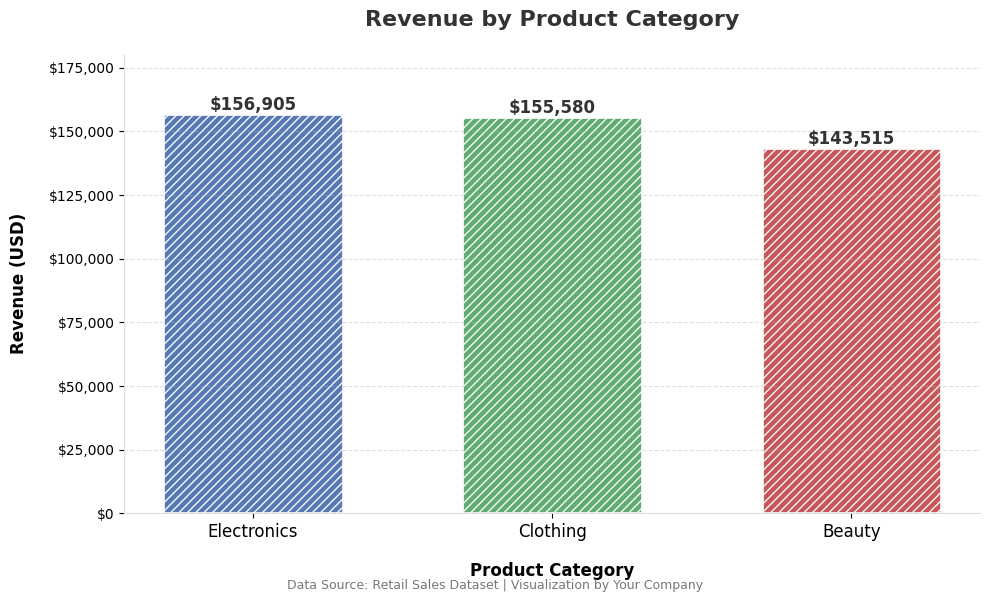

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
categories = ['Electronics', 'Clothing', 'Beauty']
revenue = [156905, 155580, 143515]
colors = ['#4C72B0', '#55A868', '#C44E52']  # Professional color palette

# Create figure
plt.figure(figsize=(10, 6), dpi=100)
ax = plt.subplot()

# Create bars with improved styling
bars = ax.bar(categories, revenue, 
              color=colors,
              width=0.6,
              edgecolor='white',
              linewidth=2)

# Add value labels with improved formatting
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}',
            ha='center', va='bottom',
            fontsize=12, fontweight='bold',
            color='#333333')

# Format y-axis
ax.set_ylim(0, max(revenue)*1.15)
ax.yaxis.set_major_formatter('${x:,.0f}')
plt.ylabel('Revenue (USD)', fontsize=12, labelpad=15, fontweight='bold')

# Format x-axis
plt.xlabel('Product Category', fontsize=12, labelpad=15, fontweight='bold')
plt.xticks(fontsize=12)

# Add title with improved styling
plt.title('Revenue by Product Category', 
          fontsize=16, pad=20, fontweight='bold', color='#333333')

# Custom grid and spines
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')

# Add subtle pattern to bars
for bar in bars:
    bar.set_hatch('////')
    bar.set_alpha(0.95)

# Add footer note
plt.figtext(0.5, 0.01, 'Data Source: Retail Sales Dataset | Visualization', 
            ha='center', fontsize=9, color='#777777')

plt.tight_layout()
plt.show()

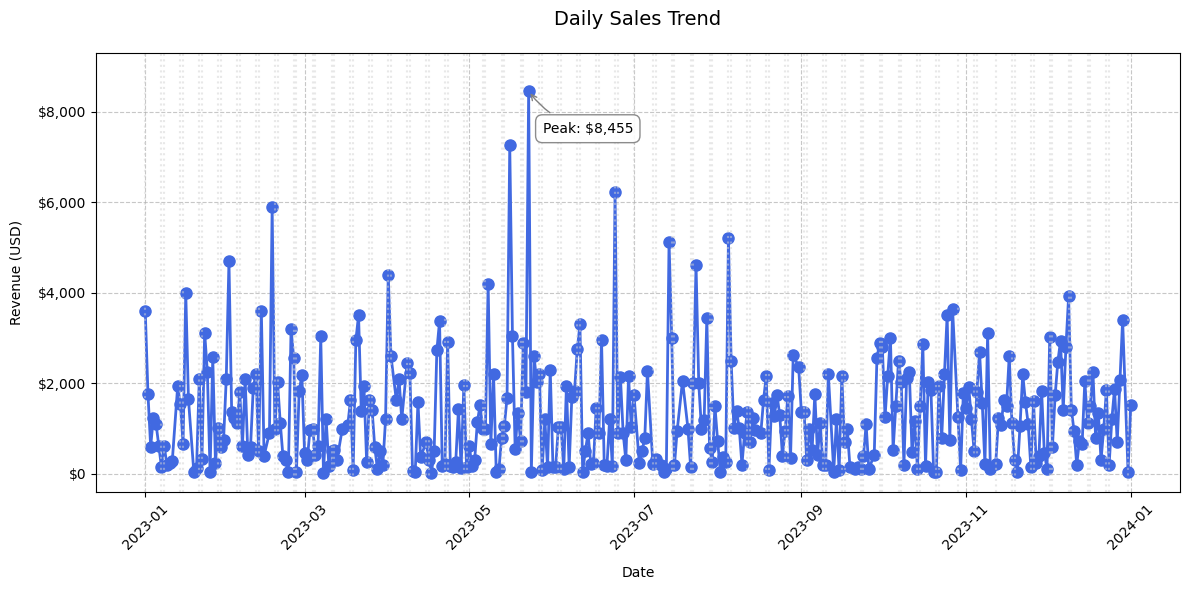

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas and process dates
daily_sales_pd = daily_sales.toPandas()
daily_sales_pd["Date"] = pd.to_datetime(daily_sales_pd["Date"])
daily_sales_pd.sort_values("Date", inplace=True)

# Create the plot
plt.figure(figsize=(12,6))
plt.plot(daily_sales_pd["Date"], 
         daily_sales_pd["Daily_Revenue"], 
         marker='o', 
         linestyle='-',
         color='royalblue',
         linewidth=2,
         markersize=8)

# Formatting
plt.title("Daily Sales Trend", pad=20, fontsize=14)
plt.xlabel("Date", labelpad=10)
plt.ylabel("Revenue (USD)", labelpad=10)

# Format y-axis as currency
ax = plt.gca()
ax.yaxis.set_major_formatter('${x:,.0f}')

# Set y-axis limit with 10% buffer above max value
max_rev = daily_sales_pd['Daily_Revenue'].max()
plt.ylim(top=max_rev * 1.10)  # 10% buffer above max value

# Rotate x-axis labels and add grid
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight weekends (example enhancement)
weekend_dates = daily_sales_pd[daily_sales_pd['Date'].dt.dayofweek >= 5]['Date']
for date in weekend_dates:
    plt.axvline(x=date, color='lightgray', linestyle=':', alpha=0.5)
    
# Add annotation for peak day - now positioned with buffer
max_date = daily_sales_pd.loc[daily_sales_pd['Daily_Revenue'].idxmax(), 'Date']
plt.annotate(f'Peak: ${max_rev:,.0f}',
             xy=(max_date, max_rev),
             xytext=(10, -30),  # Moved annotation below the point
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->',
                            connectionstyle='arc3,rad=-0.2',
                            color='gray'),
             bbox=dict(boxstyle='round,pad=0.5',
                      fc='white',
                      ec='gray',
                      alpha=0.9))

plt.tight_layout()
plt.show()

In [79]:
# Cache the cleaned dataset to avoid recomputation in further operations
df_clean.cache()

# Repartitioning data by 'Customer ID' for better parallelism
df_clean = df_clean.repartition("Customer ID")


# View the Spark execution plan for the cleaned dataset
df_clean.explain(True)



== Parsed Logical Plan ==
'RepartitionByExpression ['Customer ID]
+- Filter ((Quantity#3629 > cast(0 as float)) AND (Price per Unit#3639 > cast(0 as float)))
   +- Project [Transaction ID#3555, Date#3556, Customer ID#3557, Gender#3558, Age#3559, Product Category#3560, Quantity#3629, cast(Price per Unit#3562 as float) AS Price per Unit#3639, Total Amount#3563]
      +- Project [Transaction ID#3555, Date#3556, Customer ID#3557, Gender#3558, Age#3559, Product Category#3560, cast(Quantity#3561 as float) AS Quantity#3629, Price per Unit#3562, Total Amount#3563]
         +- Deduplicate [Price per Unit#3562, Quantity#3561, Transaction ID#3555, Total Amount#3563, Age#3559, Customer ID#3557, Product Category#3560, Date#3556, Gender#3558]
            +- Filter atleastnnonnulls(9, Transaction ID#3555, Date#3556, Customer ID#3557, Gender#3558, Age#3559, Product Category#3560, Quantity#3561, Price per Unit#3562, Total Amount#3563)
               +- Relation [Transaction ID#3555,Date#3556,Customer I

In [80]:
import time

# Example: Time a groupBy operation
start_time = time.time()

df_clean.groupBy("Product Category").sum("Total Amount").orderBy("sum(Total Amount)", ascending=False).show()

end_time = time.time()
print(f"Execution Time: {round(end_time - start_time, 2)} seconds")


+----------------+-----------------+
|Product Category|sum(Total Amount)|
+----------------+-----------------+
|     Electronics|           156905|
|        Clothing|           155580|
|          Beauty|           143515|
+----------------+-----------------+

Execution Time: 3.46 seconds


### ⚙️ Optimization Summary

To improve performance in Apache Spark:

- **Cached** the cleaned DataFrame using `df.cache()` to avoid repeated computation.
- **Repartitioned** the data using `repartition("Customer ID")` for improved parallelism and reduced shuffle.
- Used `.explain(True)` to examine the physical plan and ensure efficient execution.
- Logged **execution time** of transformations to monitor performance.
- In larger datasets, consider:
  - Using **broadcast joins** for small lookup tables.
  - Tuning **number of partitions** with `.repartition(n)` or `.coalesce(n)`.
  - Configuring Spark settings (e.g., memory, shuffle partitions) for your cluster size.
